In [1]:
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


import numpy as np

In [ ]:
from torch.utils.data import Dataset

class IrisDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __getitem__(self, index):
    X = torch.Tensor(self.X[index])
    y = torch.LongTensor(self.y[index, None])
    
    return X, y

  def __len__(self):
    return len(self.X)

In [ ]:
# open dataset from csv
dataset = pd.read_csv('Iris.csv')


In [ ]:


# transform labels to numerics
dataset.loc[dataset.Species=='Iris-setosa', 'Species'] = 0
dataset.loc[dataset.Species=='Iris-versicolor', 'Species'] = 1
dataset.loc[dataset.Species=='Iris-virginica', 'Species'] = 2

# get the features and labels from the dataset
X = dataset[dataset.columns[0:4]].values
y = dataset.Species.values.astype(np.int64)

# preprocessing with z-score normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, 
                                                      test_size=0.2)

from torch.utils.data import DataLoader

train_ds = IrisDataset(train_X, train_y)
train_loader = DataLoader(train_ds, batch_size=16, 
                             shuffle=True, num_workers=0)

valid_ds = IrisDataset(valid_X, valid_y)
valid_loader = DataLoader(valid_ds, batch_size=16, 
                             shuffle=False, num_workers=0)

test_ds = IrisDataset(test_X, test_y)
test_loader = DataLoader(test_ds, batch_size=16, 
                            shuffle=False, num_workers=0)

In [ ]:

class Net(nn.Module):
    # define nn
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 100)
        self.bn1 = nn.BatchNorm1d(100)
        
        self.fc2 = nn.Linear(100, 100)
        self.bn2 = nn.BatchNorm1d(100)
        
        self.fc3 = nn.Linear(100, 3)

    def forward(self, X):
        X1 = self.fc1(X)
        X2 = F.relu(X1)
        X2 = self.bn1(X2)
        X=X1+X2

        X1 = self.fc2(X)
        X2 = F.relu(X1)
        X2 = self.bn2(X2)
        X=X2+X1

        X1 = self.fc2(X)
        X2 = F.relu(X1)
        X2 = self.bn2(X2)
        X = X1+X2

        X = self.fc3(X)

        return X

In [ ]:
net =Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(),lr=0.01)

In [ ]:
epochs = 300
 
train_mean_losses = []
valid_mean_losses = []

valid_best_loss = np.inf


for i in range(epochs):  
    #===============================================================
    # training 
    train_losses = []
    
    print("=========================================================")
    print("Epoch {}".format(i))
    
    for iteration, batch_data in enumerate(train_loader):
        X_batch, y_batch = batch_data

        optimizer.zero_grad()
        
        out = net(X_batch)
        loss = criterion(out, y_batch.squeeze())
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss)
    
    train_mean_loss = torch.mean(torch.stack(train_losses))
    print('training loss: {:10.8f}'.format(train_mean_loss))
    
    train_mean_losses.append(train_mean_loss)
    
    #===============================================================
    # validation
    valid_losses = []
    with torch.set_grad_enabled(False):
        for iteration, batch_data in enumerate(valid_loader):
            X_batch, y_batch = batch_data

            out = net(X_batch)
            loss = criterion(out, y_batch.squeeze())
            valid_losses.append(loss)
            
        valid_mean_loss = torch.mean(torch.stack(valid_losses))
        print('validation loss: {:10.8f}'.format(valid_mean_loss))
        
        valid_mean_losses.append(valid_mean_loss)
        
        if valid_mean_loss.cpu().numpy()[()] < valid_best_loss:
            valid_best_loss = valid_mean_loss
            torch.save(net.state_dict(), "best_model.pth")
            best_epoch = i
    #===============================================================

Epoch 0
training loss: 0.60798520
validation loss: 0.34370989
Epoch 1
training loss: 0.17894566
validation loss: 0.25093928
Epoch 2
training loss: 0.08979040
validation loss: 0.19124517
Epoch 3
training loss: 0.05835341
validation loss: 0.16909632
Epoch 4
training loss: 0.09878594
validation loss: 0.16789880
Epoch 5
training loss: 0.05588047
validation loss: 0.15857455
Epoch 6
training loss: 0.04816940
validation loss: 0.14585021
Epoch 7
training loss: 0.12809481
validation loss: 0.21652500
Epoch 8
training loss: 0.08568364
validation loss: 0.13248311
Epoch 9
training loss: 0.02908302
validation loss: 0.12303453
Epoch 10
training loss: 0.06232971
validation loss: 0.11341258
Epoch 11
training loss: 0.02439443
validation loss: 0.10549522
Epoch 12
training loss: 0.01891101
validation loss: 0.09845359
Epoch 13
training loss: 0.02913864
validation loss: 0.08717903
Epoch 14
training loss: 0.02971397
validation loss: 0.07992689
Epoch 15
training loss: 0.03198232
validation loss: 0.07697501
Ep

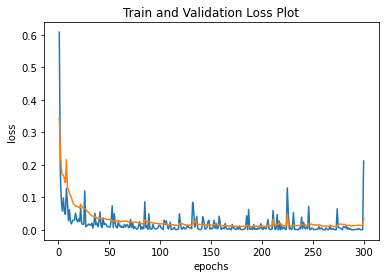

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1,epochs+1), train_mean_losses)
plt.plot(range(1,epochs+1), valid_mean_losses)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Train and Validation Loss Plot')
plt.show()

In [ ]:
inp = [
    [0.17, 0.95, 0.64, -0.7, -0.81, -0.3, 0.06, -0.05],
    [0.79, 0.03, 0.69, 0.43, 0.86, -0.08, 0.54, -0.37],
    [0.81, 0.03, 0.4, 0.78, -0.34, 0.08, -0.73, 0.74],
    [0.59, -0.89, 0.39, 0.22, -0.56, 0.22, 0.1, 0.6],
    [0.17, 0.34, 0.47, 0.67, -0.24, 0, 0.33, -0.94],
    [0.58, 0.68, 0.67, -0.59, 0.57, 0.39, -0.66, 0.53],
    [-0.79, 0.54, 0.47, 0.94, 0.64, 0.72, -0.73, 0.03],
    [-0.64, 0.38, 0.92, -0.85, 0.71, 0.14, 0.38, 0.21]
]

inp = np.array(inp)

kernel =[         
[-0.3,-0.85,0.06],
[-0.95,0.21,0.36],
[0.22,-0.07,0.59],
]
kernel=np.array(kernel)


def convolve2D(image, kernel, padding=0, strides=1):
    # Cross Correlation
    kernel = np.flipud(np.fliplr(kernel))

    # Gather Shapes of Kernel + Image + Padding
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[0]

    # Shape of Output Convolution
    xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
    output = np.zeros((xOutput, yOutput))

    # Apply Equal Padding to All Sides
    if padding != 0:
        imagePadded = np.zeros((image.shape[0] + padding*2, image.shape[1] + padding*2))
        imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image
        print(imagePadded)
    else:
        imagePadded = image

    # Iterate through image
    for y in range(image.shape[1]):
        # Exit Convolution
        if y > image.shape[1] - yKernShape:
            break
        # Only Convolve if y has gone down by the specified Strides
        if y % strides == 0:
            for x in range(image.shape[0]):
                # Go to next row once kernel is out of bounds
                if x > image.shape[0] - xKernShape:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides
                    if x % strides == 0:
                        output[x, y] = (kernel * imagePadded[x: x + xKernShape, y: y + yKernShape]).sum()
                except:
                    break

    return output





output = convolve2D(inp, kernel)
  
print(output)


[[-0.2871 -0.4633 -0.7669  0.3009 -0.5333  0.6472]
 [ 1.2086 -1.0331  1.2014  0.7325  0.9691 -1.2457]
 [-0.201  -0.8663  0.3559  0.4984 -0.7306 -0.2072]
 [-0.5619 -1.2711  1.0001 -0.2287 -0.823   1.6425]
 [-0.7524  0.612  -1.2094 -0.7547  0.4905 -0.0769]
 [-0.8129 -0.8796  0.8853 -1.2099  1.0485  0.0927]]


source https://medium.com/analytics-vidhya/2d-convolution-using-python-numpy-43442ff5f381
